In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
import copy
x_tmp = copy.deepcopy(x_test[0])

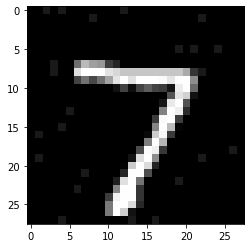

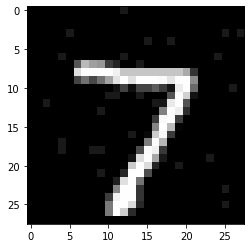

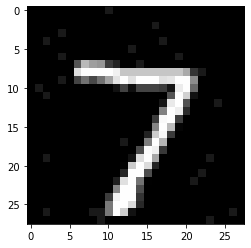

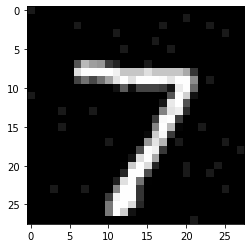

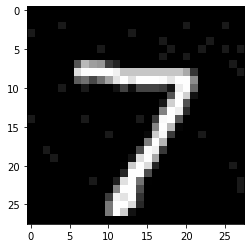

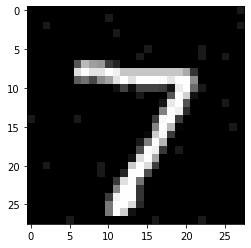

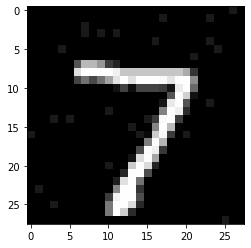

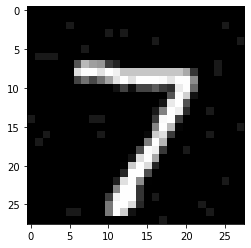

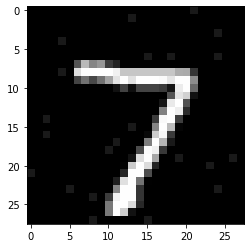

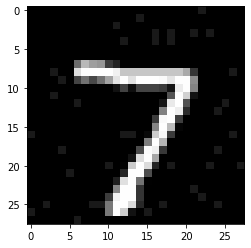

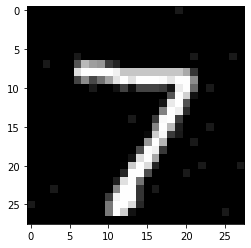

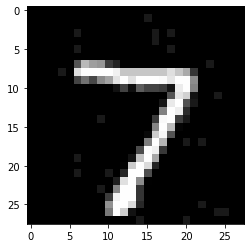

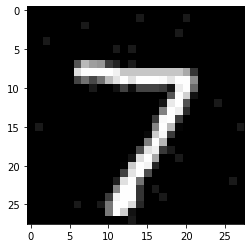

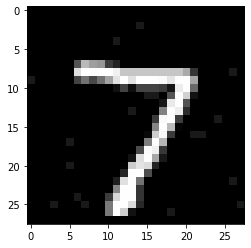

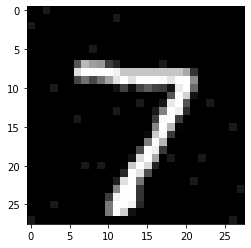

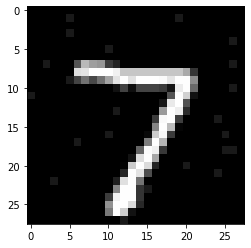

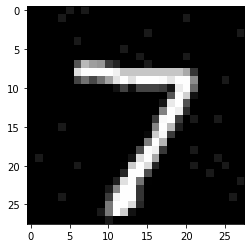

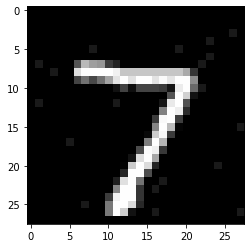

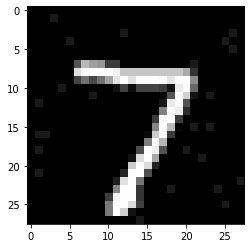

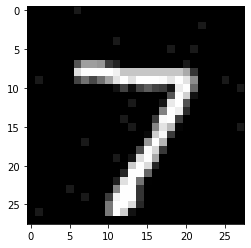

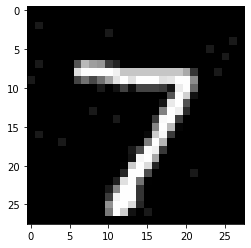

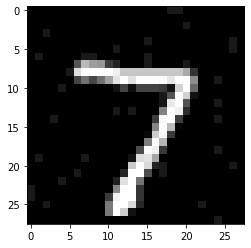

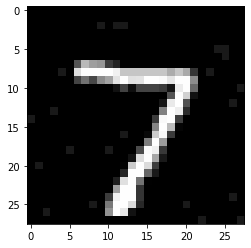

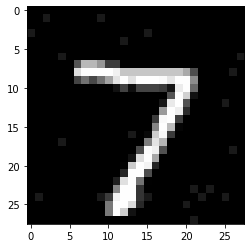

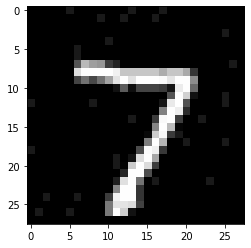

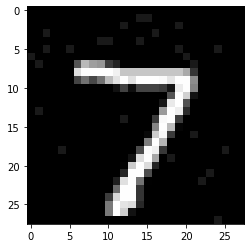

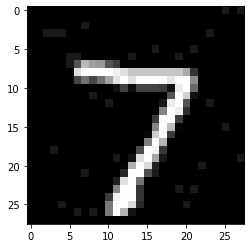

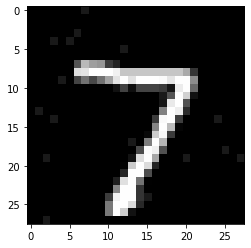

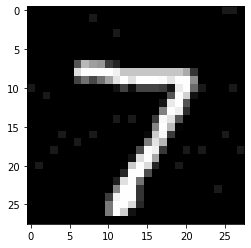

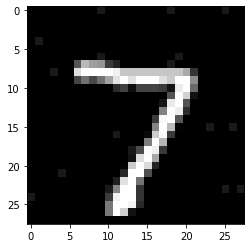

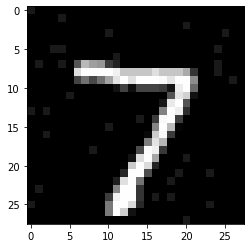

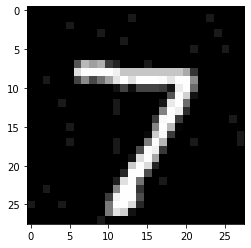

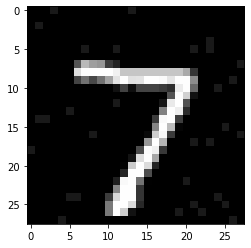

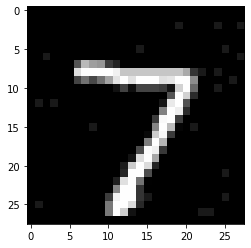

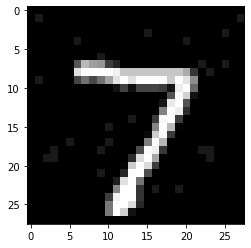

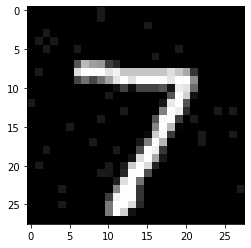

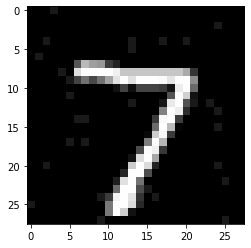

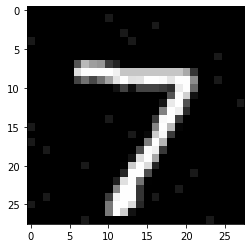

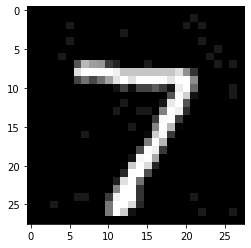

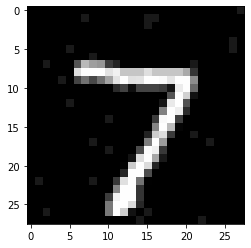

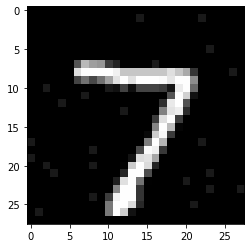

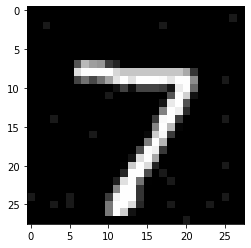

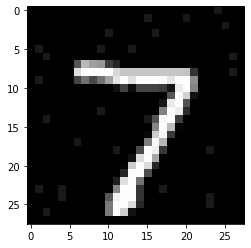

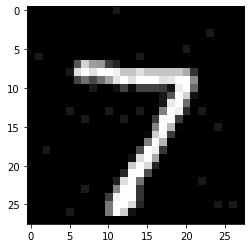

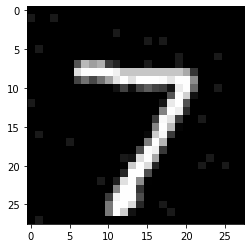

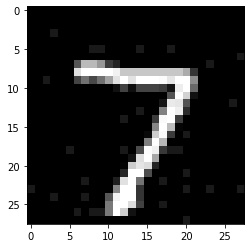

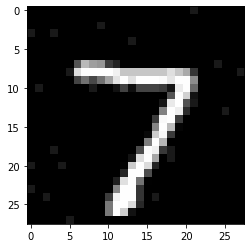

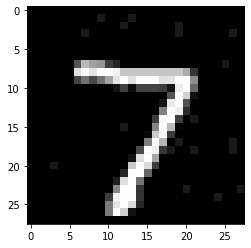

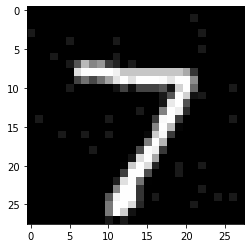

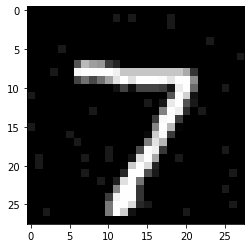

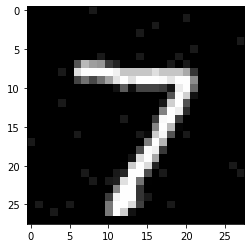

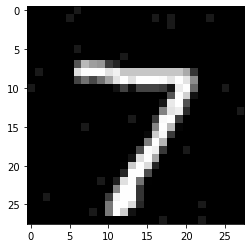

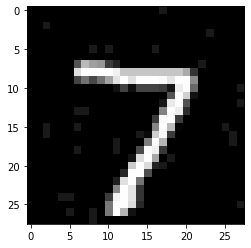

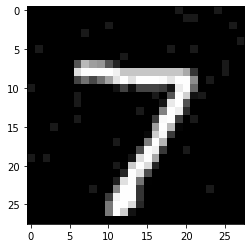

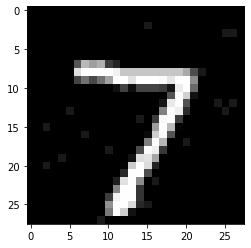

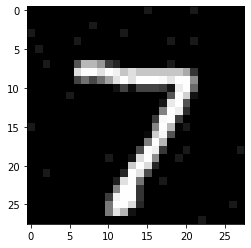

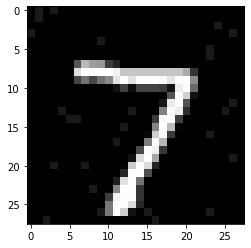

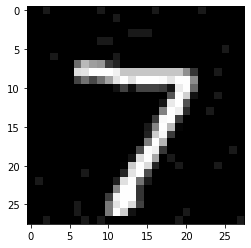

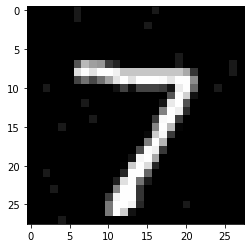

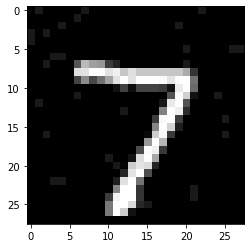

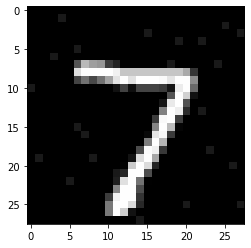

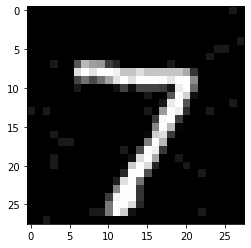

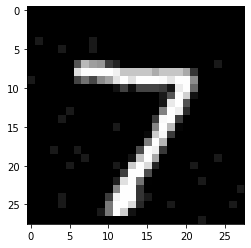

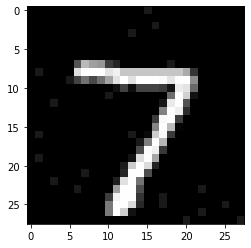

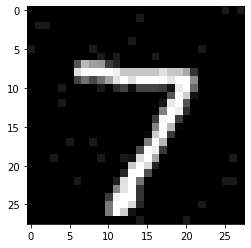

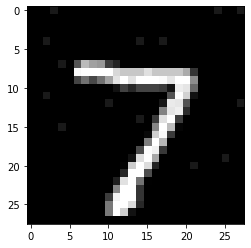

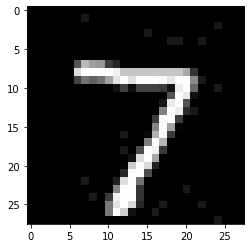

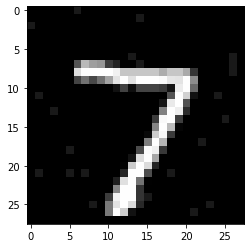

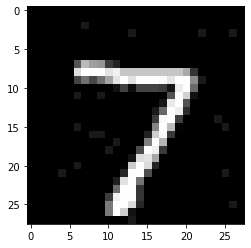

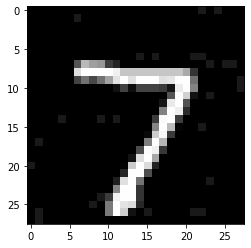

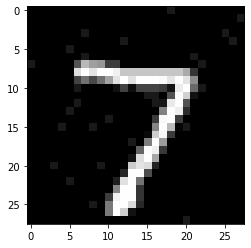

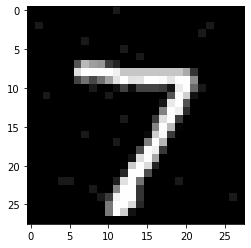

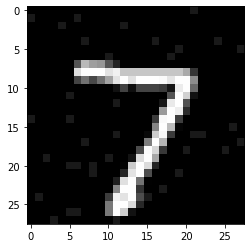

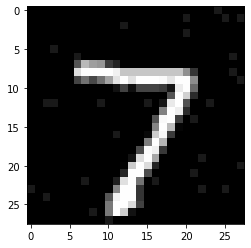

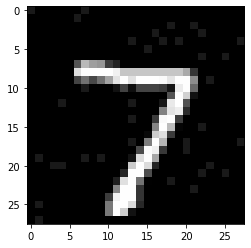

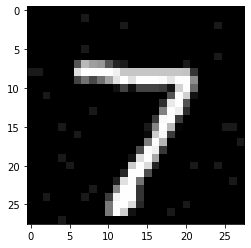

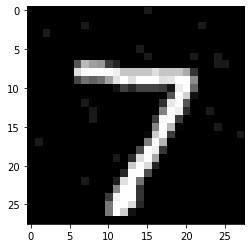

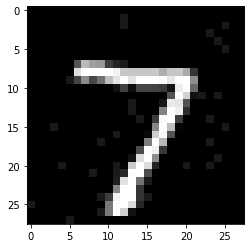

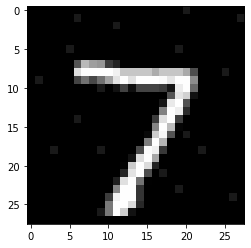

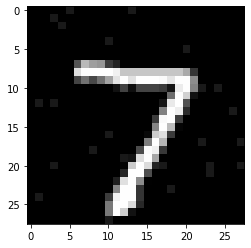

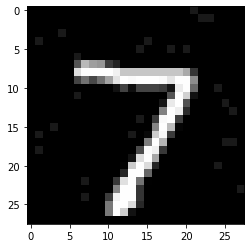

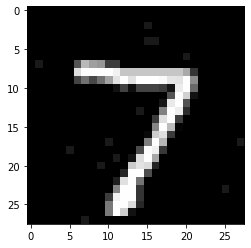

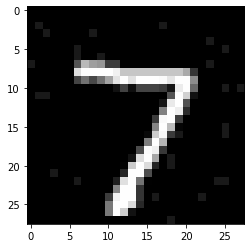

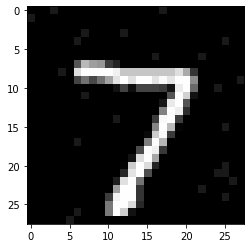

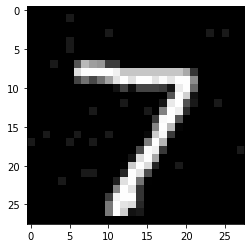

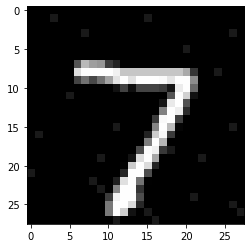

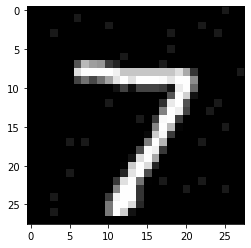

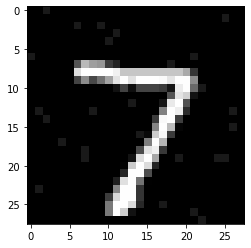

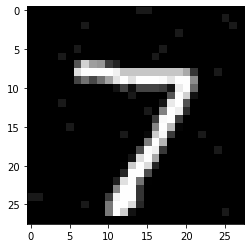

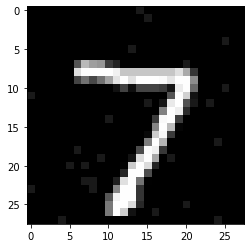

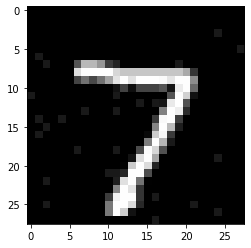

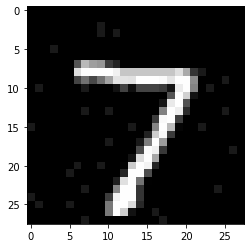

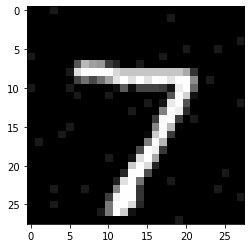

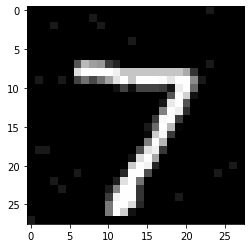

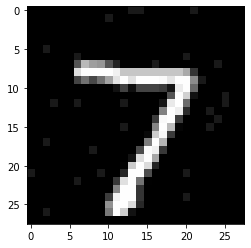

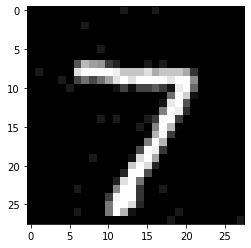

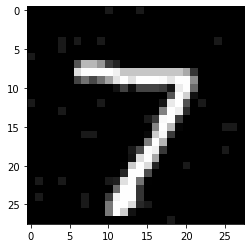

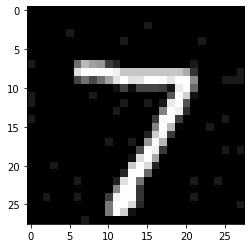

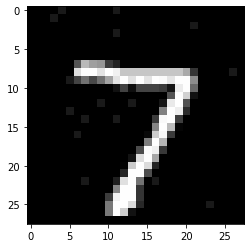

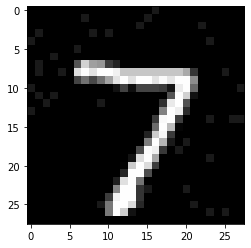

In [4]:
#产生扰动种群
x_des = []
for r in range(100):
    for i in range(28):
        for j in range(28):
            x= random.randint(0,10000)/10000
            if x <= 0.1:
                u = x_tmp[i,j] # 期望值μ
                sig = math.sqrt(0.2) # 标准差δ
                x_ = random.uniform(u - 3*sig, u + 3*sig)
                y_sig = np.exp(-(x_ - u) ** 2 /(2* sig **2))/(math.sqrt(2*math.pi)*sig)
                y_= random.randint(0,10000)/10000
                if y_ <= y_sig:
                    if x_test[0][i,j] <= 127:
                        x_tmp[i,j] += 255*0.1
                    elif x_test[0][i,j] > 127 and x_test[0][i,j] < 229:
                        y = random.randint(0,10000)/10000
                        if y <= 0.5:
                            x_tmp[i,j] += 255*0.1
                        else:
                            x_tmp[i,j] -= 255*0.1
                    elif x_test[0][i,j] >= 229:
                        x_tmp[i,j] -= 255*0.1
    x_t = x_tmp/255-x_test[0]/255
    #x_des.append(np.array (x_t.reshape(1,784)))
    x_des.append(np.array(x_t.reshape(1,784)))
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

In [5]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [6]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [7]:
x_train = x_train / 255
x_test = x_test / 255 

In [8]:
model = load_model('mnist_model.h5')

In [9]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [10]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [11]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        while GENERATION < MAX_GENERATION: 
        #for t in range(5):
            #print(Func(BEST_X))
            DB = Dis(BEST_X)    # 存储上一代的扰动程度
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                
                D_ = DIS_U[i] - DB
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i] and D_ < 0.1:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X) and D_ < 0.1:
                        BEST_X = U[i, :]
            GENERATION += 1
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            
            
            if Func(BEST_X) <= F:
                print("resume")
                D += 0.5 
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        while GENERATION < MAX_GENERATION:
        #for t in range(5):
            #print(Func(BEST_X))
            FB = Func(BEST_X)    # 存储上一代的置信度
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i]) 
                F_ = FITS_U[i] - FB
                
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i] and F_ < 0.01:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X) and F_ < 0.01:
                        BEST_X = U[i, :]
            GENERATION += 1
            #print(F_)
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            
            
            if Dis(BEST_X) <= D:
                print("attack")
                F -= 0.1
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [12]:
MAX_GENERATION = 300  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
F = 0.9   #置信度参数
D = 4.0   #扰动参数
cond = threading.Condition()
atk = Atk(cond, "attack")
re = Re(cond, "resume")

GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
re.start()
atk.start()

#re.join()
#atk.join()
if GENERATION == MAX_GENERATION:
    BEST_F = BEST_X+x_test[0]
    #print(BEST_X_F)
    plt.imshow(BEST_F.reshape(28,28),cmap='gray')
    plt.show()
    #break

attack
最优值： 0.9966281 扰动程度： 0.2672846361245676 代数： 1
最优值： 0.9966145 扰动程度： 0.35064197321782403 代数： 2
最优值： 0.996635 扰动程度： 0.3538394645673051 代数： 3
最优值： 0.9964598 扰动程度： 0.30488847458191287 代数： 4
最优值： 0.9963566 扰动程度： 0.3449242912689525 代数： 5
最优值： 0.9963242 扰动程度： 0.4048913902639545 代数： 6
最优值： 0.9960012 扰动程度： 0.3084889842482377 代数： 7
最优值： 0.9958242 扰动程度： 0.36302020430100007 代数： 8
最优值： 0.9958489 扰动程度： 0.35905293505848046 代数： 9
最优值： 0.9954867 扰动程度： 0.40602720572602635 代数： 10
最优值： 0.9953957 扰动程度： 0.42626779339288706 代数： 11
最优值： 0.99536717 扰动程度： 0.42711557292427305 代数： 12
最优值： 0.9951763 扰动程度： 0.4741732931244922 代数： 13
最优值： 0.99496704 扰动程度： 0.48990651015050607 代数： 14
最优值： 0.9947066 扰动程度： 0.5403245904737781 代数： 15
最优值： 0.9947036 扰动程度： 0.5319965505830493 代数： 16
最优值： 0.99451774 扰动程度： 0.5353594569211805 代数： 17
最优值： 0.99430376 扰动程度： 0.5808727686103166 代数： 18
最优值： 0.9942299 扰动程度： 0.5297503520530057 代数： 19
最优值： 0.9940513 扰动程度： 0.5424310290299067 代数： 20
最优值： 0.9937186 扰动程度： 0.6131436728882311 代数： 21
最优值：

最优值： 0.793257 扰动程度： 4.219464403974071 代数： 174
最优值： 0.7937389 扰动程度： 4.201080418035444 代数： 175
最优值： 0.79246867 扰动程度： 4.286475542274272 代数： 176
最优值： 0.78429157 扰动程度： 4.33995906968255 代数： 177
最优值： 0.77882296 扰动程度： 4.4131661012172945 代数： 178
最优值： 0.76755583 扰动程度： 4.464824888254615 代数： 179
最优值： 0.7659689 扰动程度： 4.517006183694873 代数： 180
最优值： 0.76184 扰动程度： 4.497676653987696 代数： 181
最优值： 0.7582185 扰动程度： 4.526566118337744 代数： 182
最优值： 0.7563217 扰动程度： 4.596236710728022 代数： 183
最优值： 0.7559426 扰动程度： 4.548469381901349 代数： 184
最优值： 0.752818 扰动程度： 4.5665954932953445 代数： 185
最优值： 0.7489443 扰动程度： 4.62444980243212 代数： 186
最优值： 0.7341269 扰动程度： 4.709096959781224 代数： 187
最优值： 0.7373792 扰动程度： 4.6787844385951525 代数： 188
最优值： 0.7289985 扰动程度： 4.800810423533081 代数： 189
最优值： 0.727517 扰动程度： 4.898778148189057 代数： 190
最优值： 0.7106588 扰动程度： 4.988625119162127 代数： 191
最优值： 0.70752096 扰动程度： 5.033507167312473 代数： 192
最优值： 0.69783974 扰动程度： 4.9390782108846505 代数： 193
resume
最优值： 0.7018501 扰动程度： 4.913368536920905 代数： 194
att

In [13]:
BEST_X

array([ 3.66768629e-04,  0.00000000e+00, -0.00000000e+00,  2.61477218e-03,
        0.00000000e+00,  0.00000000e+00,  3.24608565e-01,  3.09136862e-04,
        1.15529738e-03,  4.38619457e-03,  0.00000000e+00,  4.38161543e-03,
        0.00000000e+00,  3.37014771e-04,  4.07709222e-03,  0.00000000e+00,
        2.96713441e-02,  1.36073995e-03,  1.76941648e-03,  0.00000000e+00,
        3.49282390e-01,  5.70644247e-04,  1.19710678e-01,  0.00000000e+00,
        0.00000000e+00,  9.12887452e-05,  1.27709933e-03,  1.37034279e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.07726209e-03,
        0.00000000e+00,  1.87508336e-01,  0.00000000e+00,  9.21068773e-03,
        4.91795785e-03,  4.69157774e-01,  0.00000000e+00,  2.83737988e-02,
        0.00000000e+00,  2.55637513e-04,  1.32240753e-02,  7.53329488e-03,
        2.14344010e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.71786172e-04,  0.00000000e+00,  1.25392247e-02,
        0.00000000e+00,  

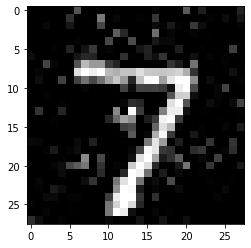

In [15]:
BEST = BEST_X + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [16]:
result=model.predict(BEST_X.reshape(1,784))
result[0]

array([0.03750902, 0.06797595, 0.1722124 , 0.22787984, 0.03627369,
       0.28074306, 0.0521142 , 0.01458593, 0.08774115, 0.02296462],
      dtype=float32)

In [14]:
# test
count = 0
for i in range(784):
    if BEST_X[i] != 0:
        count+=1
print(count)

448


In [15]:
# test
count = 0
for i in range(784):
    if BEST_X[i] > 0.8:
        count+=1
print(count)

4


In [55]:
V=[1.175,0.8,1.5,1.32,1.912]
for i in range(5):
                    if V[i] > 1:
                        V[i] =1-(V[i]-1)
                       
V = [round(i,3) for i in V]
V

[0.825, 0.8, 0.5, 0.68, 0.088]